In [1]:
! pip install qiskit

In [2]:
from collections import Counter
from typing import Tuple, List
from networkx import MultiGraph
from networkx import nx
from networkx.algorithms import bipartite
from sympy.combinatorics import Permutation
import matplotlib.pyplot as plt

In [3]:
class SurfaceCodeGraph(MultiGraph):
    def __init__(self, sigma: Tuple[Tuple[int]], alpha: Tuple[Tuple[int]]):
        super().__init__()
        self.sigma = sigma  # should include singletons corresponding to fixed points
        self.alpha = alpha  # should include singletons corresponding to fixed points
        f = self.compute_phi()
        self.phi = self.permlist_to_tuple(f)
        self.build_node_info()  # print dictionary for [sigma, alpha, phi]
        self.node_dict = self.sigma_dict, self.alpha_dict, self.phi_dict
        
        self.node_info = ["sigma:", self.sigma_dict, 
                          "alpha:", self.alpha_dict, 
                          "phi:", self.phi_dict]

        self.code_graph = nx.MultiGraph()

        # Create black nodes for each cycle in sigma along with white nodes
        # representing "half edges" around the black nodes
        for cycle in self.sigma:
            self.code_graph.add_node(cycle, bipartite=1)
            for node in cycle:
                self.code_graph.add_node(node, bipartite=0)
                self.code_graph.add_edge(cycle, node)

        # Create black nodes for each cycle in phi along with white nodes
        # representing "half edges" around the black nodes
        for cycle in self.phi:
            self.code_graph.add_node(cycle, bipartite=1)
            for node in cycle:
                self.code_graph.add_edge(cycle, node)

        # Create nodes for each cycle in alpha then
        # glue the nodes corresponding to a the pairs
        for pair in self.alpha:
            self.code_graph.add_node(pair)
            self.code_graph = nx.contracted_nodes(self.code_graph, pair[0], pair[1], self_loops=True)
            # Now contract pair with pair[0] to make sure edges (white nodes) are labeled
            # by the pairs in alpha to keep track of the gluing from the previous step
            self.code_graph = nx.contracted_nodes(self.code_graph, pair, pair[0], self_loops=True)
            
        # Define the white and black nodes. White correspond to edges labeled by 
        # cycles in alpha. Black correspond to nodes labeled by cycles in sigma
        # (vertices) and phi (faces)
        self.black_nodes, self.white_nodes = bipartite.sets(self.code_graph)

    def permlist_to_tuple(self, perms):
        """
        convert list of lists to tuple of tuples in order to have two level iterables
        that are hashable for the dictionaries used later
        """
        return tuple(tuple(perm) for perm in perms)

    def compute_phi(self):
        """compute the list of lists full cyclic form of phi (faces of dessin [sigma, alpha, phi])"""
        s = Permutation(self.sigma)
        a = Permutation(self.alpha)
        f = ~(a * s)
        f = f.full_cyclic_form  # prints permutation as a list of lists including all singletons (fixed points)
        return f

    def build_node_info(self):
        count = -1

        self.sigma_dict = dict()
        for count, cycle in enumerate(self.sigma):
            self.sigma_dict[cycle] = count

        self.phi_dict = dict()
        for count, cycle in enumerate(self.phi, start=count + 1):
            self.phi_dict[cycle] = count

        self.alpha_dict = dict()
        for count, pair in enumerate(self.alpha, start=count + 1):
            self.alpha_dict[pair] = count
        return tuple([self.sigma_dict, self.alpha_dict, self.phi_dict])
    
    def boundary_1(self, edge):
        """
        compute boundary of a single edge given by a white node (cycle in alpha)
        """
        boundary1 = [node for node in self.code_graph.neighbors(edge) if node in self.sigma_dict]
        return boundary1
    
    def del_1(self, edges: List[Tuple[int]]):
        """
        boundary of a list of edges, i.e. an arbitrary 1-chain over Z/2Z
        """

        boundary_list = [self.boundary_1(edge) for edge in edges]
        a = Counter([y for x in boundary_list for y in x])
        boundary_list = [x[0] for x in a.items() if x[1] % 2 == 1]
        return boundary_list

    def boundary_2(self, face):
        """
        compute boundary of a single face
        """
        boundary = self.code_graph.neighbors(face)
        return boundary

    def del_2(self, faces: List[Tuple[int]]):
        """
        boundary of a list of faces, i.e. an arbitrary 2-chain over Z/2Z
        """

        boundary_list = [self.boundary_2(face) for face in faces]
        a = Counter([y for x in boundary_list for y in x])
        boundary_list = [x[0] for x in a.items() if x[1] % 2 == 1]
        return boundary_list

    def coboundary_1(self, star):
        """
        compute coboundary of a single star
        """
        coboundary = self.code_graph.neighbors(star)
        return coboundary

    def delta_1(self, stars: List[Tuple[int]]):
        """
        coboundary of a list of stars, i.e. an arbitrary 0-cochain over Z/2Z
        """
        coboundary_list = [self.coboundary_1(star) for star in stars]
        a = Counter([y for x in coboundary_list for y in x])
        coboundary_list = [x[0] for x in a.items() if x[1] % 2 == 1]
        return coboundary_list
    
    def coboundary_2(self, edge):
        """
        compute coboundary of a single edge given by a white node (cycle in alpha)
        """
        coboundary2 = [node for node in self.code_graph.neighbors(edge) if node in self.phi_dict]
        return coboundary2
    
    def delta_2(self, edges: List[Tuple[int]]):
        """
        coboundary of a list of edges, i.e. an arbitrary 1-cochain over Z/2Z
        given by a list of cycles in alpha
        """
        coboundary_list = [self.coboundary_2(edge) for edge in edges]
        a = Counter([y for x in coboundary_list for y in x])
        coboundary_list = [x[0] for x in a.items() if x[1] % 2 == 1]
        return coboundary_list

    def euler_characteristic(self):
        """
        Compute the Euler characteristic of the surface in which the graph is embedded
        """
        chi = len(self.phi) - len(self.alpha) + len(self.sigma)
        return (chi)

    def genus(self):
        """
        Compute the genus of the surface in which the graph is embedded
        """
        g = int(-(len(self.phi) - len(self.alpha) + len(self.sigma) - 2) / 2)
        return (g)
    
    
    def draw(self, node_type='', layout = ''):
        """
        Draw graph with vertices, edges, and faces labeled by colored nodes and their integer indices 
        corresponding to the qubit indices for the surface code
        """
        if not node_type in ['cycles', 'dict']:
            raise ValueError('node_type can be "cycles" or "dict"')
        
        if layout == 'spring':
            pos=nx.spring_layout(self.code_graph)
        if layout == 'spectral':
            pos=nx.spectral_layout(self.code_graph)
        if layout == 'planar':
            pos=nx.planar_layout(self.code_graph)
        if layout == 'shell':
            pos=nx.shell_layout(self.code_graph)
        if layout == 'circular':
            pos=nx.circular_layout(self.code_graph)
        if layout == 'spiral':
            pos=nx.spiral_layout(self.code_graph)
        if layout == 'random':
            pos=nx.random_layout(self.code_graph)
        # white nodes
        nx.draw_networkx_nodes(self.code_graph, pos,
                       nodelist=list(self.alpha),
                       node_color='c',
                       node_size=500,
                    alpha=0.3)
        # vertex nodes
        nx.draw_networkx_nodes(self.code_graph, pos,
                       nodelist=list(self.sigma),
                       node_color='b',
                       node_size=500,
                    alpha=0.6)
         # face nodes
        nx.draw_networkx_nodes(self.code_graph, pos,
                       nodelist=list(self.phi),
                       node_color='r',
                       node_size=500,
                    alpha=0.6)
        # edges
        nx.draw_networkx_edges(self.code_graph, pos, width=1.0, alpha=0.5)

        labels={}

        if node_type == 'cycles':
            '''
            label nodes the cycles of sigma, alpha, and phi
            '''
            for node in self.alpha_dict:
                # stuff = self.alpha_dict[node]
                labels[node]=f'$e$({node})'
            for node in self.sigma_dict:
                # something = self.sigma_dict[node]
                labels[node]=f'$v$({node})'
            for node in self.phi_dict:
                # something2 = self.phi_dict[node]
                labels[node]=f'$f$({node})'
            nx.draw_networkx_labels(self.code_graph, pos, labels, font_size=12)

        if node_type == 'dict':
            '''
            label nodes with v, e, f and indices given by node_dict corresponding to
            qubit indices of surface code
            '''

            for node in self.alpha_dict:
                # stuff = self.alpha_dict[node]
                labels[node]=f'$e$({self.alpha_dict[node]})'
            for node in self.sigma_dict:
                # something = self.sigma_dict[node]
                labels[node]=f'$v$({self.sigma_dict[node]})'
            for node in self.phi_dict:
                # something2 = self.phi_dict[node]
                labels[node]=f'$f$({self.phi_dict[node]})'
            nx.draw_networkx_labels(self.code_graph, pos, labels, font_size=12)
        
        # plt.axis('off')
        # plt.savefig("labels_and_colors.png") # save as png
        plt.show() # display

In [4]:
sigma = ((0,1,2),(3,4,5),(6,7))
alpha = ((0,3),(1,6),(2,4),(5,7))
SCG = SurfaceCodeGraph(sigma, alpha)
SCG

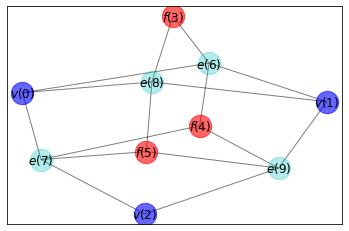

In [5]:
SCG.phi
SCG.node_info
SCG.code_graph.nodes
bipartite.sets(SCG.code_graph)
SCG.white_nodes
SCG.black_nodes
SCG.euler_characteristic()
SCG.genus()
SCG.del_2([(1,3,7)])
SCG.del_2([(0, 4), (1,3,7)])
SCG.delta_1([(0,1,2)])
SCG.delta_1([(0,1,2), (3,4,5)])
SCG.boundary_1((0,3))
SCG.boundary_1((1,6))
SCG.del_1([(0,3), (1,6)])
SCG.coboundary_2((0,3))
SCG.coboundary_2((1,6))
SCG.delta_2([(0,3), (1,6)])

SCG.draw('dict', 'spring')

In [6]:
from typing import Tuple

from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister

# from SurfaceCodes.surface_code_class import SurfaceCodeGraph
# from SurfaceCodes.utilites import permlist_to_tuple


class SurfaceCodeCircuit(QuantumCircuit):

    def __init__(self, sigma: Tuple[Tuple[int]], alpha: Tuple[Tuple[int]]):
        super().__init__()
        self.sigma = sigma
        self.alpha = alpha

        self.scgraph = SurfaceCodeGraph(self.sigma, self.alpha)

        '''
        Compute the permutation corresponding to phi and create a 
        'surface code circuit' based on a (multi)graph 'surface_code_graph'
        given by sigma, alpha, and phi
        Create quantum and classical registers based on the number of nodes in G
        '''
        # f = self.scgraph.compute_phi()
        self.phi = self.scgraph.phi

        self.qr = QuantumRegister(len(self.scgraph.code_graph.nodes))
        self.cr = ClassicalRegister(len(self.scgraph.code_graph.nodes))
        self.circ = QuantumCircuit(self.qr, self.cr)

        self.node_info = self.scgraph.node_dict
        self.sigma_dict, self.alpha_dict, self.phi_dict = self.node_info

        for cycle in self.sigma:
            self.circ.h(self.sigma_dict[cycle])

        for cycle in self.phi:
            self.circ.h(self.phi_dict[cycle])
            

    def x_measurement(self, qubit: int, cbit: int):
        """Measure 'qubit' in the X-basis, and store the result in 'cbit'
        :param qubit, cbit:
        :return None
        """
        # circuit.measure = measure  # fix a bug in qiskit.circuit.measure
        self.circ.h(qubit)
        self.circ.measure(qubit, cbit)
        self.circ.h(qubit)

    def star_syndrome_measure(self, vertex: Tuple[int]):
        """
        Applies CX gates to surrounding qubits of a star then measures star qubit in X-basis
        :param vertex:
        :return:  self.circ, self.scgraph, self.node_info
        """

        for node in self.scgraph.code_graph.neighbors(vertex):
            self.circ.cx(self.sigma_dict[vertex], self.alpha_dict[node])

        self.circ.barrier()
        self.x_measurement(self.sigma_dict[vertex], self.sigma_dict[vertex])
        self.circ.barrier()

        return self.circ, self.scgraph, self.node_info

    def face_syndrome_measure(self, vertex: Tuple[int]):
        """
        Applies CZ gates to surrounding qubits of a face then measures face qubit in X-basis
        :param vertex:
        :return:
        """

        for node in self.scgraph.code_graph.neighbors(vertex):
            self.circ.cz(self.phi_dict[vertex], self.alpha_dict[node])

        self.circ.barrier()
        self.x_measurement(self.phi_dict[vertex], self.phi_dict[vertex])
        self.circ.barrier()

        return self.circ, self.scgraph, self.node_info

    def product_Z(self, faces):
        """
        Pauli product Z operator for arbitrary 2-chain boundary
        """

        boundary_nodes = self.scgraph.del_2(faces)
        for node in boundary_nodes:
            self.circ.z(self.alpha_dict[node])

    def product_X(self, stars):
        """
        Pauli product X operator for arbitrary 0-cochain coboundary
        """
        coboundary_nodes = self.scgraph.delta_1(stars)
        for node in coboundary_nodes:
            self.circ.x(self.alpha_dict[node])
            
    
    
            
    def draw_graph(self, node_type='', layout = ''):
        if layout == 'spring':
            pos=nx.spring_layout(self.scgraph.code_graph)
        if layout == 'spectral':
            pos=nx.spectral_layout(self.scgraph.code_graph)
        if layout == 'planar':
            pos=nx.planar_layout(self.scgraph.code_graph)
        if layout == 'shell':
            pos=nx.shell_layout(self.scgraph.code_graph)
        if layout == 'circular':
            pos=nx.circular_layout(self.scgraph.code_graph)
        if layout == 'spiral':
            pos=nx.spiral_layout(self.scgraph.code_graph)
        if layout == 'random':
            pos=nx.random_layout(self.scgraph.code_graph)
        if node_type == 'cycles':
            self.scgraph.draw('cycles', layout)
        if node_type == 'dict':
            self.scgraph.draw('dict', layout)

In [7]:
SCC = SurfaceCodeCircuit(sigma, alpha)
SCC.circ.draw()

┌───┐
 q0_0: ┤ H ├
       ├───┤
 q0_1: ┤ H ├
       ├───┤
 q0_2: ┤ H ├
       ├───┤
 q0_3: ┤ H ├
       ├───┤
 q0_4: ┤ H ├
       ├───┤
 q0_5: ┤ H ├
       └───┘
 q0_6: ─────
            
 q0_7: ─────
            
 q0_8: ─────
            
 q0_9: ─────
            
c0: 10/═════

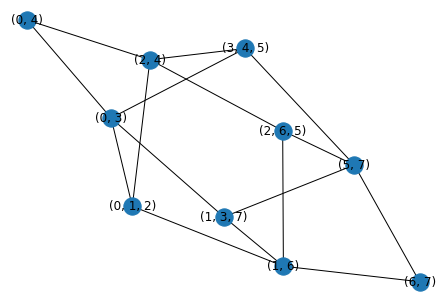

In [8]:
nx.draw(SCC.scgraph.code_graph, with_labels = True)

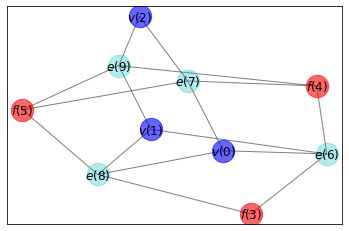

In [9]:
SCC.draw_graph('dict', 'spring')

In [10]:
SCC.node_info
SCC.sigma
SCC.alpha
SCC.phi
SCC.scgraph.code_graph.nodes

NodeView(((0, 1, 2), (3, 4, 5), (6, 7), (0, 4), (1, 3, 7), (2, 6, 5), (0, 3), (1, 6), (2, 4), (5, 7)))

In [11]:
SCC.star_syndrome_measure(((0,1,2)))
SCC.face_syndrome_measure(((2, 6, 5)))
SCC.product_Z([(0, 4), (2, 6, 5)])
SCC.product_X([(3, 4, 5), (6, 7)])
SCC.circ.draw()

┌───┐                ░ ┌───┐┌─┐┌───┐ ░           ░               ░      »
 q0_0: ┤ H ├──■────■────■───░─┤ H ├┤M├┤ H ├─░───────────░───────────────░──────»
       ├───┤  │    │    │   ░ └───┘└╥┘└───┘ ░           ░               ░      »
 q0_1: ┤ H ├──┼────┼────┼───░───────╫───────░───────────░───────────────░──────»
       ├───┤  │    │    │   ░       ║       ░           ░               ░      »
 q0_2: ┤ H ├──┼────┼────┼───░───────╫───────░───────────░───────────────░──────»
       ├───┤  │    │    │   ░       ║       ░           ░               ░      »
 q0_3: ┤ H ├──┼────┼────┼───░───────╫───────░───────────░───────────────░──────»
       ├───┤  │    │    │   ░       ║       ░           ░               ░      »
 q0_4: ┤ H ├──┼────┼────┼───░───────╫───────░───────────░───────────────░──────»
       ├───┤  │    │    │   ░       ║       ░           ░ ┌───┐┌─┐┌───┐ ░      »
 q0_5: ┤ H ├──┼────┼────┼───░───────╫───────░──■──■──■──░─┤ H ├┤M├┤ H ├─░──────»
       └───┘┌─┴─┐  │    │   ░       ║       ░  │  │  │  ░ └───┘└╥┘└───┘ ░ ┌───┐»
 q0_6: ─────┤ X ├──┼────┼───░───────╫───────░──┼──┼──┼──░───────╫───────░─┤ Z ├»
            └───┘┌─┴─┐  │   ░       ║       ░  │  │  │  ░       ║       ░ ├───┤»
 q0_7: ──────────┤ X ├──┼───░───────╫───────░──■──┼──┼──░───────╫───────░─┤ Z ├»
                 └───┘┌─┴─┐ ░       ║       ░     │  │  ░       ║       ░ ├───┤»
 q0_8: ───────────────┤ X ├─░───────╫───────░─────■──┼──░───────╫───────░─┤ X ├»
                      └───┘ ░       ║       ░        │  ░       ║       ░ ├───┤»
 q0_9: ─────────────────────░───────╫───────░────────■──░───────╫───────░─┤ Z ├»
                            ░       ║       ░           ░       ║       ░ └───┘»
c0: 10/═════════════════════════════╩═══════════════════════════╩══════════════»
                                    0                           5              »
«            
« q0_0: ─────
«            
« q0_1: ─────
«            
« q0_2: ─────
«            
« q0_3: ─────
«            
« q0_4: ─────
«            
« q0_5: ─────
«       ┌───┐
« q0_6: ┤ X ├
«       ├───┤
« q0_7: ┤ X ├
«       └───┘
« q0_8: ─────
«            
« q0_9: ─────
«            
«c0: 10/═════
«

In [12]:
sigma = ((0,1),(2,3,4),(5,6,7),(8,9),(10,11,12),(13,14,15,16),(17,18,19,20),(21,22,23),(24,25,26),(27,28,29,30),(31,32,33,34),(35,36,37),(38,39),(40,41,42),(43,44,45),(46,47))
alpha = ((0,2),(1,10),(3,5),(4,14),(6,8),(7,18),(9,22),(11,13),(12,24),(15,17),(16,28),(19,21),(20,32),(23,36),(25,27),(26,38),(29,31),(30,41),(33,35),(34,44),(37,47),(39,40),(42,43),(45,46))

In [13]:
SCG = SurfaceCodeGraph(sigma, alpha)
SCG.genus()

0

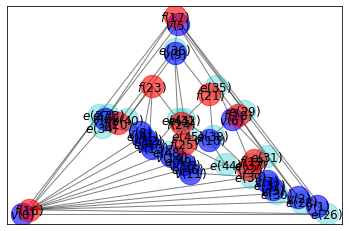

In [14]:
SCG.draw('dict', 'planar')

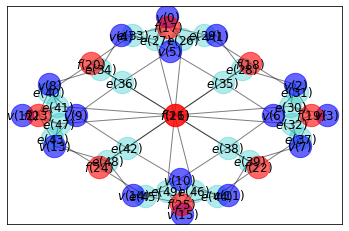

In [15]:
SCG.draw('dict', 'spectral')

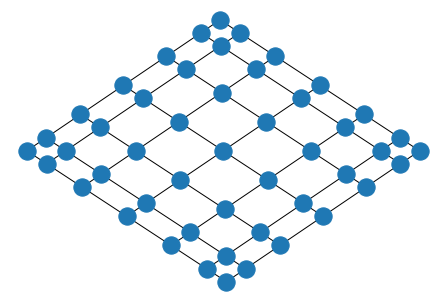

In [16]:
len(SCG.code_graph.nodes())
len(SCG.sigma)
len(SCG.alpha)
len(SCG.phi)
SCG.phi
SCG.code_graph.nodes()
SCG.code_graph.remove_node((0, 10, 24, 38, 40, 43, 46, 37, 23, 9, 6, 3))
len(SCG.code_graph.nodes())
nx.draw_spectral(SCG.code_graph, with_labels = False)

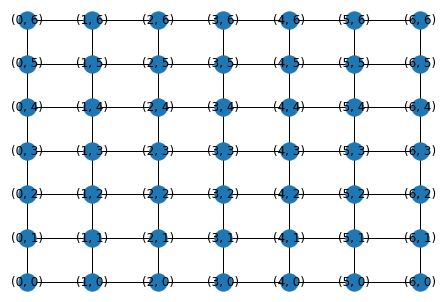

In [17]:
G = nx.Graph()
pos = dict()

for x in range(7):
    for y in range(7):
        G.add_node((x,y))
        pos[(x,y)] = (x,y)
        if x>0:
            G.add_edge((x-1,y),(x,y))
        if y>0:
            G.add_edge((x,y),(x,y-1))
nx.draw(G, pos=pos, with_labels = True)

In [18]:
nx.is_isomorphic(SCG.code_graph, G)
G1, G2 = SCG.code_graph, G
GM = nx.isomorphism.GraphMatcher(G1,G2)
GM.is_isomorphic()
GM.mapping

{(0, 1): (0, 0),
 (0, 2): (1, 0),
 (1, 2, 14, 11): (1, 1),
 (1, 10): (0, 1),
 (2, 3, 4): (2, 0),
 (3, 5): (3, 0),
 (4, 5, 18, 15): (3, 1),
 (4, 14): (2, 1),
 (5, 6, 7): (4, 0),
 (6, 8): (5, 0),
 (7, 8, 22, 19): (5, 1),
 (7, 18): (4, 1),
 (8, 9): (6, 0),
 (9, 22): (6, 1),
 (10, 11, 12): (0, 2),
 (11, 13): (1, 2),
 (12, 13, 28, 25): (1, 3),
 (12, 24): (0, 3),
 (13, 14, 15, 16): (2, 2),
 (15, 17): (3, 2),
 (16, 17, 32, 29): (3, 3),
 (16, 28): (2, 3),
 (17, 18, 19, 20): (4, 2),
 (19, 21): (5, 2),
 (20, 21, 36, 33): (5, 3),
 (20, 32): (4, 3),
 (21, 22, 23): (6, 2),
 (23, 36): (6, 3),
 (24, 25, 26): (0, 4),
 (25, 27): (1, 4),
 (26, 27, 41, 39): (1, 5),
 (26, 38): (0, 5),
 (27, 28, 29, 30): (2, 4),
 (29, 31): (3, 4),
 (30, 31, 44, 42): (3, 5),
 (30, 41): (2, 5),
 (31, 32, 33, 34): (4, 4),
 (33, 35): (5, 4),
 (34, 35, 47, 45): (5, 5),
 (34, 44): (4, 5),
 (35, 36, 37): (6, 4),
 (37, 47): (6, 5),
 (38, 39): (0, 6),
 (39, 40): (1, 6),
 (40, 41, 42): (2, 6),
 (42, 43): (3, 6),
 (43, 44, 45): (4, 6

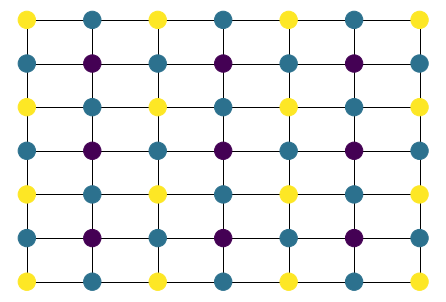

In [19]:
node_color = {(x[0], x[1]): 1-((x[0]+x[1])%2)/2 for x in G.nodes()}

for y in range(1,7,2):
    for z in range(1,7,2):
        node_color[(y,z)] = .2
        
node_color = [node_color[x] for x in sorted(node_color.keys())]

nx.draw(G, pos = pos, node_color = node_color)